In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "5"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.abspath(".."))

slurm0-a3nodeset-2
/home/akarsh_sakana_ai/nca-alife/src/science_notebooks
/home/akarsh_sakana_ai/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
group.add_argument("--seed", type=int, default=0)
group.add_argument("--save_dir", type=str, default=None)

group = parser.add_argument_group("model")
group.add_argument("--grid_size", type=int, default=64)
group.add_argument("--rollout_steps", type=int, default=4096)

group = parser.add_argument_group("data")
group.add_argument("--n_rollout_imgs", type=int, default=32)
group.add_argument("--clip_model", type=str, default="clip-vit-base-patch32") # clip-vit-base-patch32 or clip-vit-large-patch14

group = parser.add_argument_group("optimization")
group.add_argument("--bs", type=int, default=512)
group.add_argument("--start", type=int, default=0) # start range for params search
group.add_argument("--end", type=int, default=262144) # end range for params search

NameError: name 'group' is not defined

In [4]:
cfg_default = dict(
    seed=0, save_dir=None,

    grid_size=64, rollout_steps=2048,
    n_rollout_imgs=32,

    bs=512,
    start=0, end=262144,
)

n_splits = 8
split_size = (2**18)//n_splits

seed = 0
cfgs = []
for i in range(n_splits):
    cfg = cfg_default.copy()
    cfg.update(seed=seed, start=i*split_size, end=(i+1)*split_size)
    cfg.update(save_dir=f"/home/akarsh_sakana_ai/nca-alife-data/gol/split={i}_{seed=}")
    cfgs.append(cfg)

print(len(cfgs))

8


In [5]:
commands = experiment_utils.create_commands(cfgs, prefix='python main_sweep_gol.py', out_file='../science_scripts/main_sweep_gol.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python main_sweep_gol.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/gol/split=0_seed=0" --grid_size=64 --rollout_steps=2048 --n_rollout_imgs=32 --bs=512 --start=0      --end=32768 
python main_sweep_gol.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/gol/split=1_seed=0" --grid_size=64 --rollout_steps=2048 --n_rollout_imgs=32 --bs=512 --start=32768  --end=65536 
python main_sweep_gol.py --seed=0 --save_dir="/home/akarsh_sakana_ai/nca-alife-data/gol/split=2_seed=0" --grid_size=64 --rollout_steps=2048 --n_rollout_imgs=32 --bs=512 --start=65536  --end=98304  
...
8 commands


# Visualize Results

In [6]:
import jax
import jax.numpy as jnp
from jax.random import split

In [7]:
data = []
all_params = []
for cfg in cfgs[:]:
    save_dir = cfg['save_dir']
    print(save_dir)
    data.append(util.load_pkl(save_dir, "data"))
    all_params.append(util.load_pkl(save_dir, "all_params"))

/home/akarsh_sakana_ai/nca-alife-data/gol/split=0_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=1_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=2_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=3_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=4_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=5_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=6_seed=0
/home/akarsh_sakana_ai/nca-alife-data/gol/split=7_seed=0


In [8]:
data = jax.tree.map(lambda *x: jnp.concatenate(x, axis=0), *data)
all_params = jax.tree.map(lambda *x: jnp.concatenate(x, axis=0), *all_params)

2024-09-03 19:15:29.608875: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [9]:
cgol = 6152 # conway's game of life

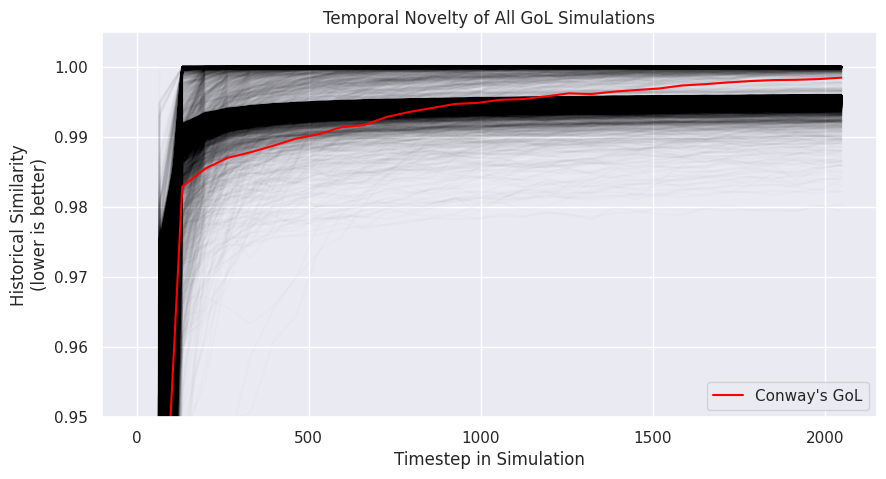

In [172]:
timesteps = np.linspace(0, 2048, 32)
plt.figure(figsize=(10, 5))
plt.plot(timesteps, data['loss_novelty'][:10000].T, c='black', alpha=0.01)
plt.plot(timesteps, data['loss_novelty'][cgol], c='red', label="Conway's GoL");
plt.legend()
plt.ylim(0.95, 1.005)
plt.xlabel("Timestep in Simulation")
plt.ylabel("Historical Similarity\n(lower is better)")
plt.title("Temporal Novelty of All GoL Simulations")
plt.show()

In [11]:
time_cutoff = 2048+64
oe_scores = data['loss_novelty'][:, 1:time_cutoff//64].mean(axis=-1)

percentile of cgol:  0.9668006896972656


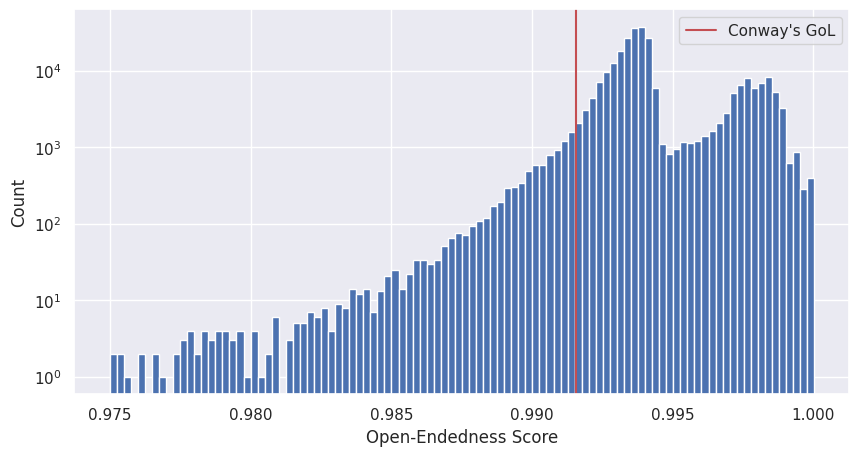

In [173]:
plt.figure(figsize=(10, 5))
plt.hist(oe_scores, bins=100);
plt.axvline(oe_scores[cgol], c='r', label="Conway's GoL")
plt.yscale('log')
cgol_percentile = (oe_scores[cgol]<oe_scores).sum()/len(oe_scores)
print('percentile of cgol: ', cgol_percentile.item())

plt.xlabel("Open-Endedness Score")
plt.ylabel("Count")
plt.legend()
plt.show()

In [44]:
idx_best = oe_scores.argsort()

In [14]:
idx_best[0]

Array(133519, dtype=int32)

In [15]:
from models.models_gol import int2binary, GameOfLife

def rule2english(x):
    x = np.array(int2binary(x))
    dead_rules = x[:9]
    alive_rules = x[9:]
    
    dead_rules = [str(i) for i in np.nonzero(dead_rules)[0]]
    dead_rules = ",".join(dead_rules)
    alive_rules = [str(i) for i in np.nonzero(alive_rules)[0]]
    alive_rules = ",".join(alive_rules)

    rule = f"a dead cell with {{{dead_rules}}} live neighbors becomes live\na live cell with {{{alive_rules}}} live neighbors lives"
    return rule

def unroll_params(rng, params, sim, rollout_len=2048, img_size=64, ret='vid'):
    def step(state, _rng):
        next_state = sim.step_state(_rng, state, params)
        return next_state, state
    state_init = sim.init_state(rng, params)
    state_final, state_vid = jax.lax.scan(step, state_init, split(rng, rollout_len))
    if ret=='vid':
        vid = jax.vmap(partial(sim.render_state, params=params, img_size=img_size))(state_vid)
        return vid
    elif ret=='img':
        img = sim.render_state(state_final, params=params, img_size=img_size)
        return img
    
sim = GameOfLife()
unroll_fn = partial(unroll_params, sim=sim)

In [16]:
rng = jax.random.PRNGKey(1)

In [17]:
import imageio

In [68]:
for i in idx_best[:16].tolist()+[cgol]:
    params = all_params[i]
    vid = jax.vmap(unroll_fn, in_axes=(0, None))(split(rng, 16), params)
    print(i)
    print((jnp.abs(vid[:, 1:]-vid[:, :-1])).mean().item())
    print()

    vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)

    # plt.figure(figsize=(20, 10))
    # plt.imshow(rearrange(vid[:4, ::256], "B T H W D -> (B H) (T W) D"))
    # plt.grid(False)
    # plt.title(f"{params}\n{rule2english(params)}")
    # plt.show()
    vid = rearrange(vid[:16, :2048:2], "(R C) T H W D -> T (R H) (C W) D", R=4)
    vid = np.array((vid*255).astype(jnp.uint8))
    imageio.mimwrite(f"/home/akarsh_sakana_ai/nca-alife-data/gol/vids/{i}.gif", vid, fps=15)

133519
0.9245015382766724

7803
0.9421007037162781

14782
0.9217796325683594

7291
0.940741240978241

33823
0.911983847618103

34335
0.9464942216873169

34591
0.94743412733078

55871
0.8902833461761475

15923
0.8053731322288513

55615
0.8819025158882141

55903
0.9452502131462097

36703
0.9263873100280762

7787
0.9840583205223083

2067
0.9381324648857117

56127
0.9245851635932922

2579
0.9396926164627075

6152
0.023513570427894592



In [51]:
vid.shape

(16, 2048, 66, 66, 3)

In [64]:
"".join([str(a) for a in int2binary(i)[::-1]])

'000001110001111011'

7290
0.7347294688224792



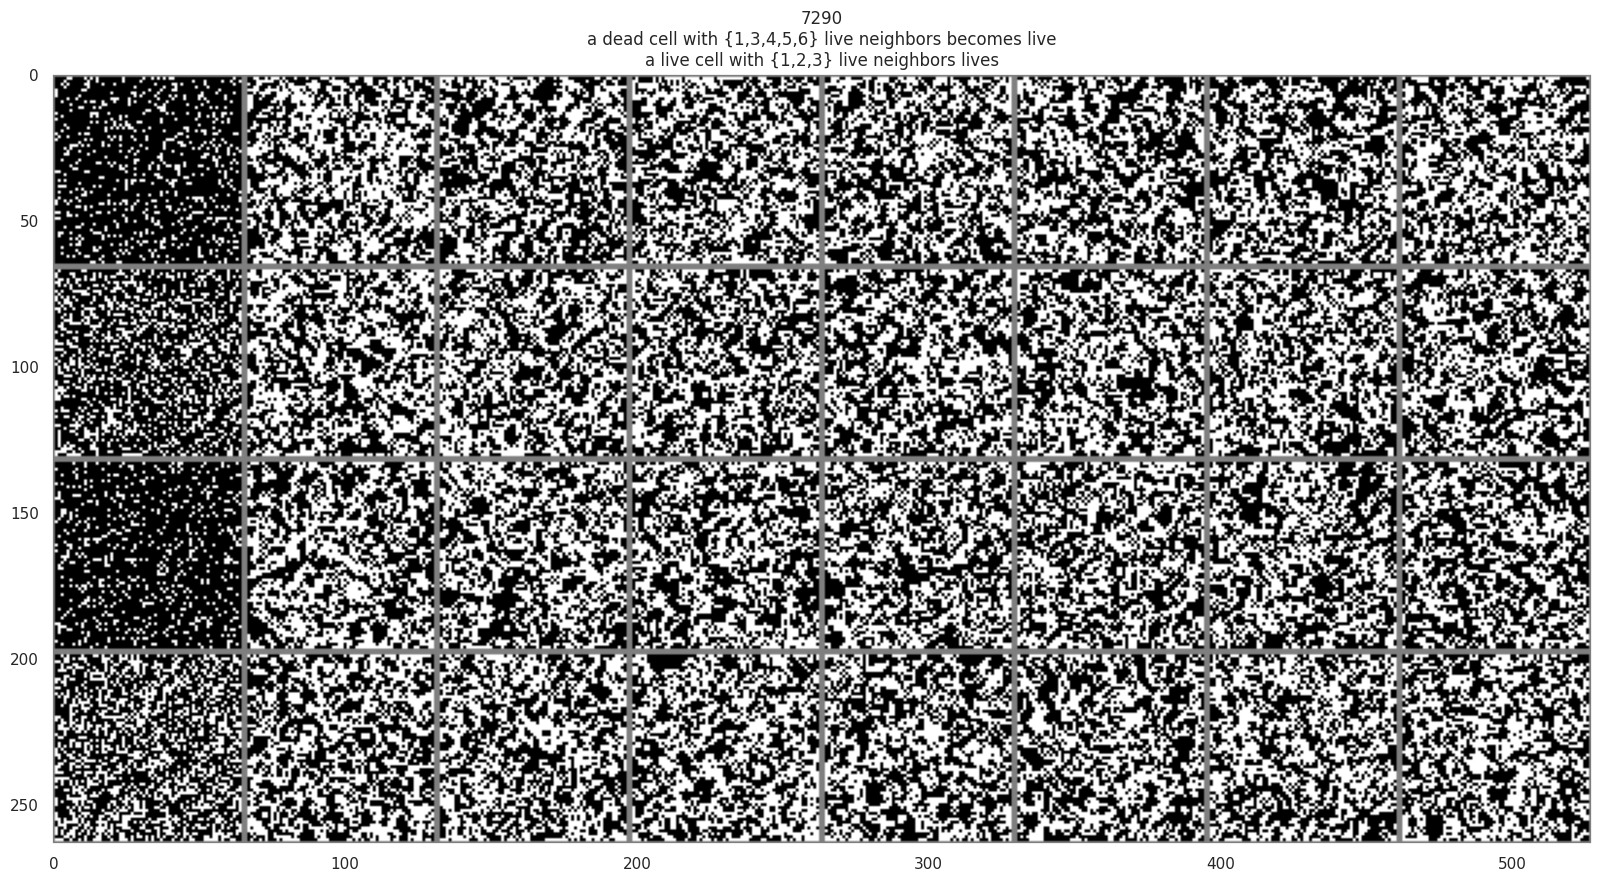

In [66]:
i = idx_best[3]
i = 7290
params = all_params[i]
vid = jax.vmap(unroll_fn, in_axes=(0, None))(split(rng, 16), params)
print(i)
print((jnp.abs(vid[:, 1:]-vid[:, :-1])).mean().item())
print()
vid = jnp.pad(vid, ((0, 0), (0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0.5)
plt.figure(figsize=(20, 10))
plt.imshow(rearrange(vid[:4, ::256], "B T H W D -> (B H) (T W) D"))
plt.grid(False)
plt.title(f"{params}\n{rule2english(params)}")
plt.show()

In [18]:
from umap import UMAP

In [19]:
oe_scores.shape

(262144,)

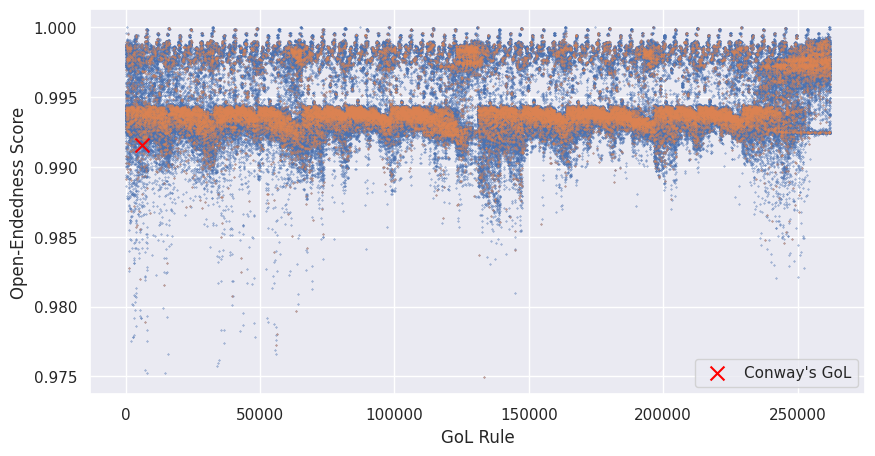

In [175]:
plt.figure(figsize=(10, 5))
plt.scatter(all_params, oe_scores, s=0.1)
plt.scatter(all_params[idx_best[::10]], oe_scores[idx_best[::10]], s=0.1)

plt.scatter(cgol, oe_scores[cgol], s=100.0, c='red', marker='x', label="Conway's GoL")
plt.legend()
plt.xlabel("GoL Rule")
plt.ylabel("Open-Endedness Score")
plt.show()

In [123]:
np.random.seed(0)
z = data['z_img_final'][idx_best[::10]]
print(z.shape)
# img_final = pop['img_final']
# z_1d = UMAP(n_components=1, metric='cosine').fit_transform(z)
# z_2d = UMAP(n_components=2, metric='cosine').fit_transform(z)
umap_fn = UMAP(n_components=2, metric='cosine').fit(z)
z_2d = umap_fn.transform(z)
z_2d_cgol = umap_fn.transform(data['z_img_final'][cgol][None])[0]
print(z_2d.shape)

(26215, 512)
(26215, 2)


In [125]:
z_2d_cgol.shape

(2,)

Text(0.5, 1.0, 'UMAP of GoL Simulation CLIP Embeddings colored by Open-Ended Score')

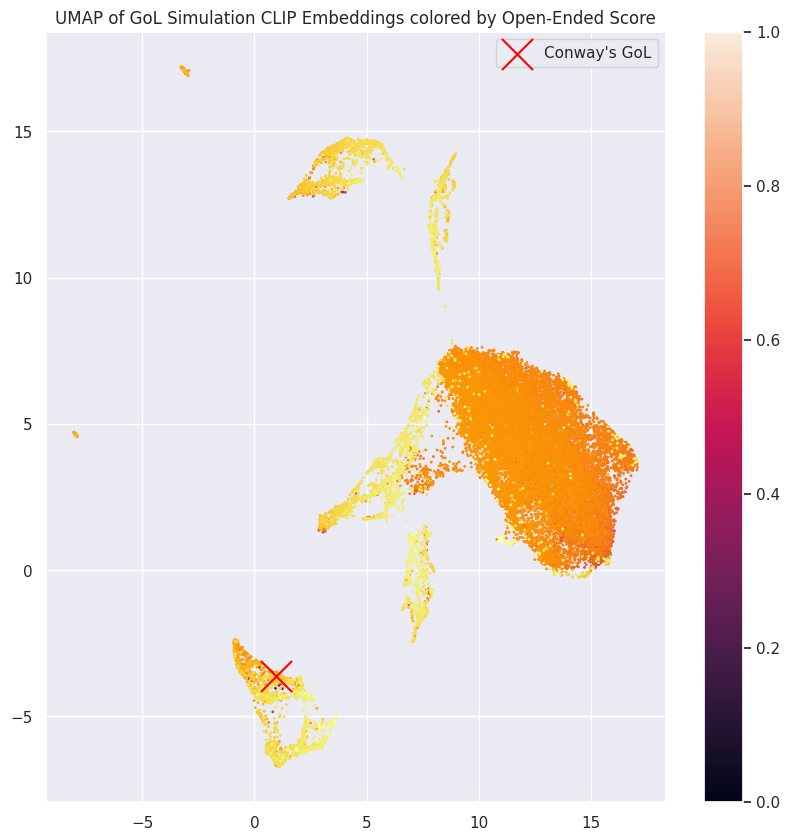

In [176]:
plt.figure(figsize=(10, 10))
plt.scatter(*z_2d.T, c=oe_scores[idx_best[::10]], s=1.0, cmap='inferno')
plt.scatter(*z_2d_cgol, c='red', s=500.0, marker='x', label="Conway's GoL")
plt.colorbar()
plt.legend()
# plt.xlim(0,20)
# plt.ylim(-7,15)
plt.title("UMAP of GoL Simulation CLIP Embeddings colored by Open-Ended Score")

In [133]:
all_params_bin = jax.vmap(int2binary)(all_params)
all_params_bin.shape

(262144, 18)

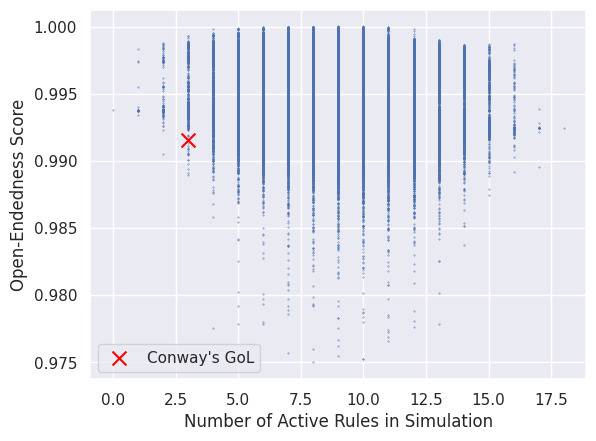

In [178]:
plt.scatter(all_params_bin.sum(axis=-1), oe_scores, s=0.1)
plt.scatter(all_params_bin[cgol].sum(), oe_scores[cgol], c='red', s=100.0, marker='x', label="Conway's GoL")

plt.legend()

plt.xlabel("Number of Active Rules in Simulation")
plt.ylabel("Open-Endedness Score")
plt.show()

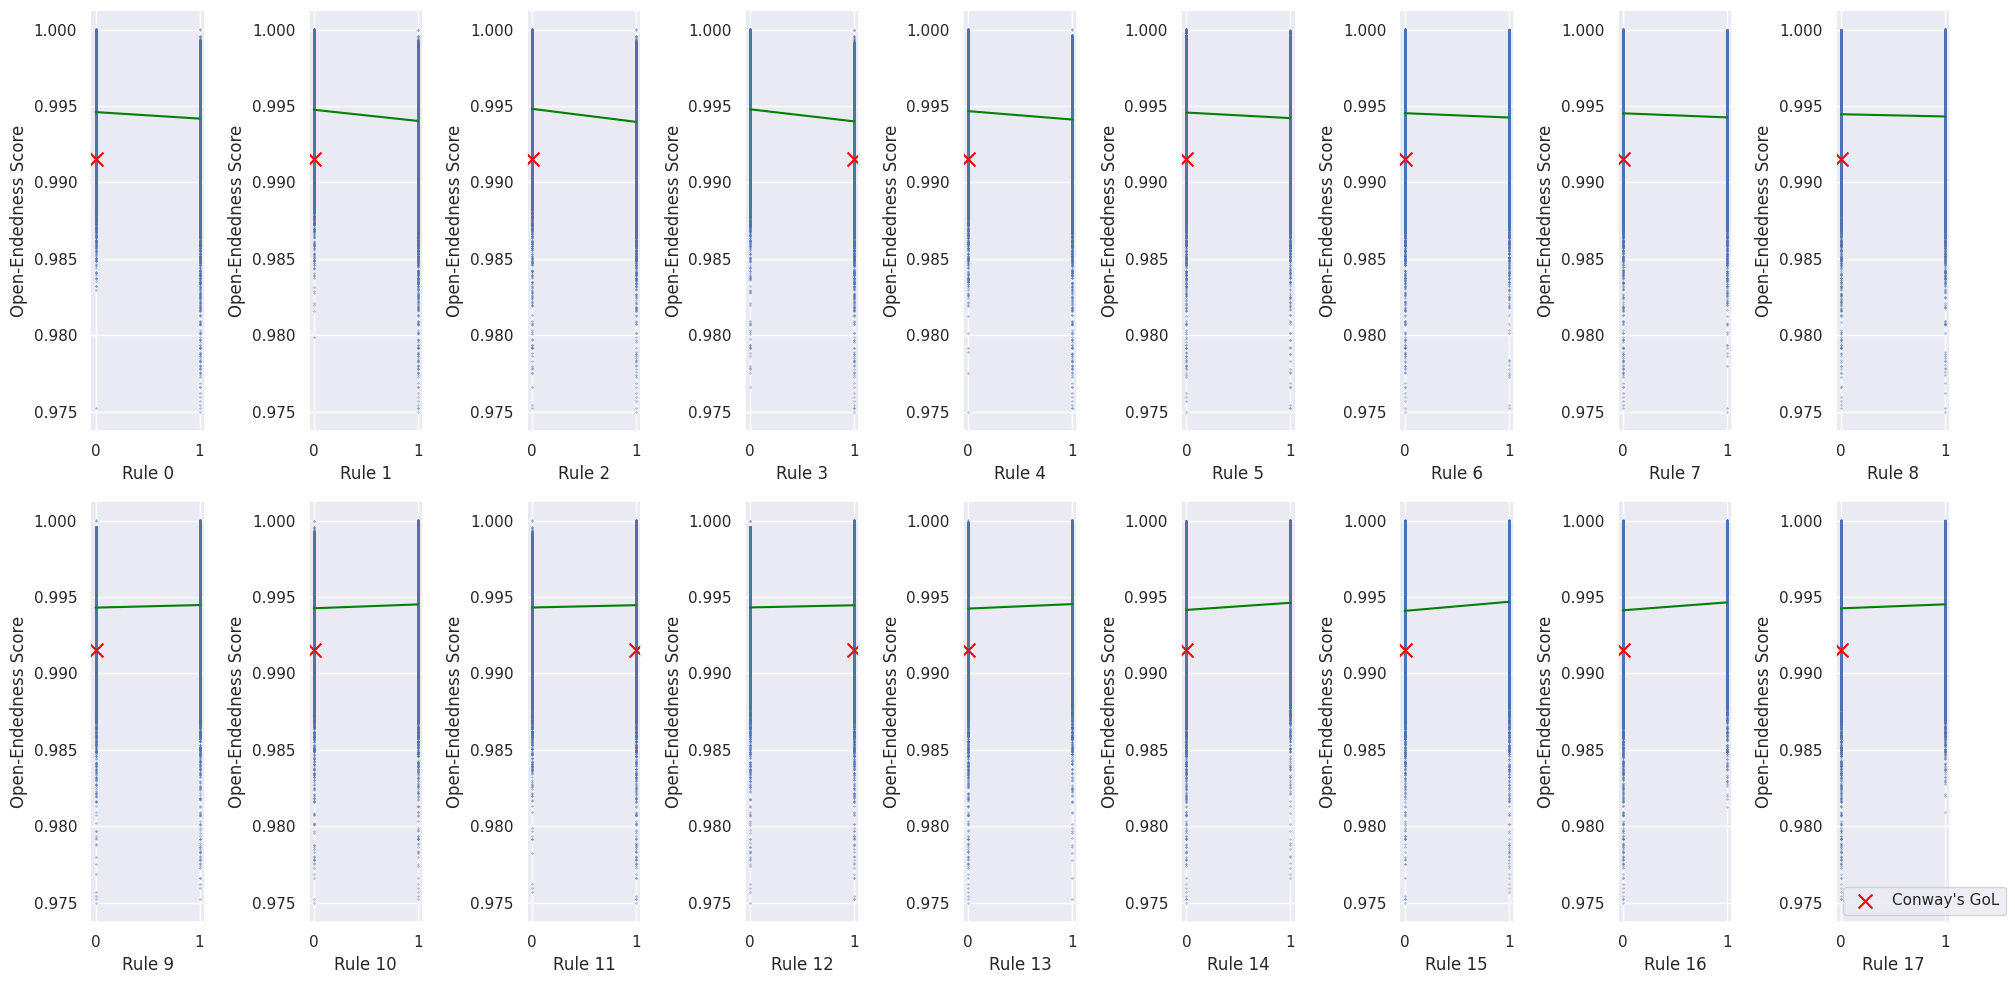

In [181]:
plt.figure(figsize=(20, 10))
for i in range(18):
    plt.subplot(2, 9, i+1)
    plt.scatter(all_params_bin[:, i], oe_scores, s=0.1)
    plt.scatter(all_params_bin[cgol, i], oe_scores[cgol], c='red', s=100.0, marker='x', label="Conway's GoL")
    plt.plot([jnp.mean(oe_scores[all_params_bin[:, i]==0]), jnp.mean(oe_scores[all_params_bin[:, i]==1])], c='green')
    plt.xlabel(f"Rule {i}")
    plt.ylabel("Open-Endedness Score")

plt.legend()
plt.tight_layout()
plt.show()

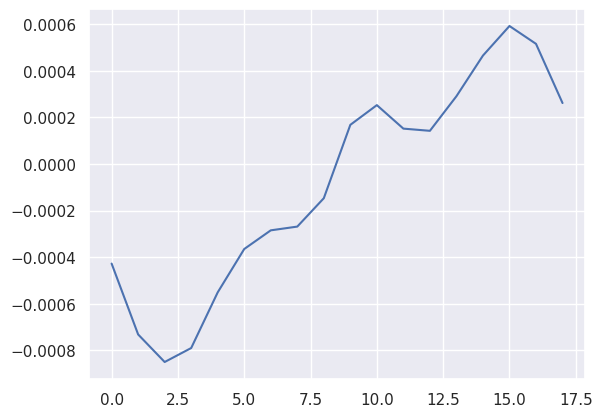

In [156]:
slopes = []
for i in range(18):
    slopes.append(jnp.mean(oe_scores[all_params_bin[:, i]==1])-jnp.mean(oe_scores[all_params_bin[:, i]==0]))
plt.plot(slopes)
# plt.plot(slopes[:9])
# plt.plot(slopes[9:])
plt.show()

In [81]:
gol = 6152
all_params[gol]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0], dtype=int32)

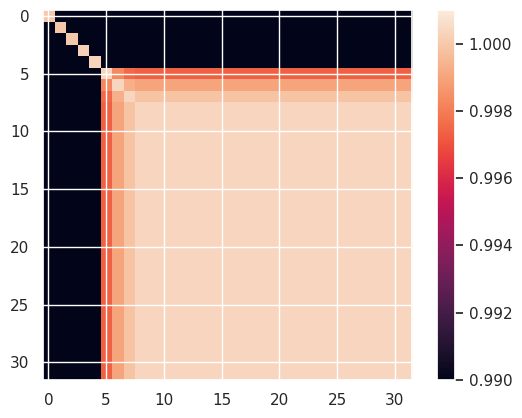

In [118]:
a = data['scores'][246756]
plt.imshow(a, vmin=0.99, vmax=1.001)
plt.colorbar()

(0.95, 1.005)

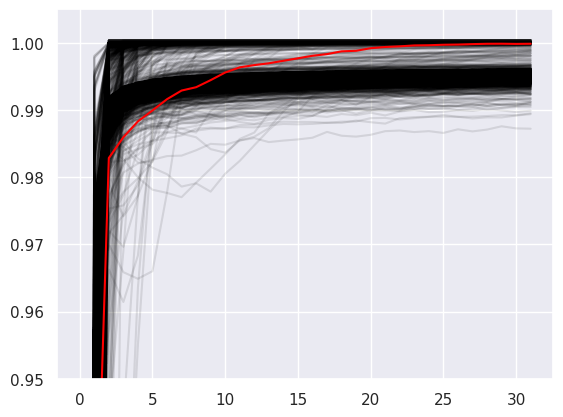

In [88]:
plt.plot(data['similarities'][::50].T, c='black', alpha=0.1);
plt.plot(data['similarities'][gol], c='red');
plt.ylim(0.95, 1.005)
# plt.xlim(0, 5)

In [173]:
oe = data['similarities'][:, 1:].mean(axis=-1)
oe.shape

(262144,)

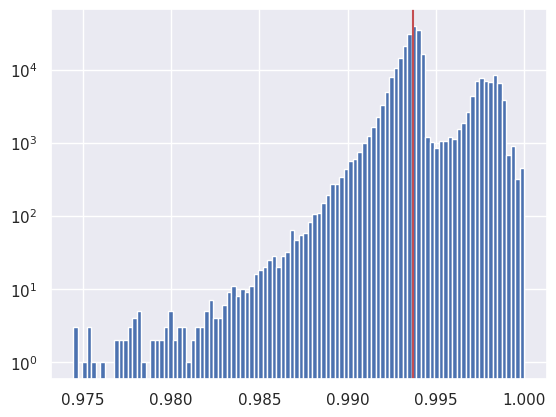

In [174]:
plt.hist(oe, bins=100);
plt.axvline(oe[gol], c='r')
plt.yscale('log')

In [175]:
(oe[gol]>oe).sum()/len(oe)

0.4320716857910156

In [176]:
oe.argmin()

7803

In [183]:
def conv2d_3x3_sum(x):
    x_padded = jnp.pad(x, pad_width=1, mode='wrap')
    kernel = jnp.ones((3, 3))
    return jax.lax.conv_general_dilated(
            x_padded[None, None, :, :],  # Add batch and channel dimensions
            kernel[None, None, :, :],  # Add input and output channel dimensions
            window_strides=(1, 1),
            padding='VALID',
            dimension_numbers=('NCHW', 'OIHW', 'NCHW'))[0, 0]
def step_ca(state, _, params):
    state_f = state.astype(float)
    n_neighbors = conv2d_3x3_sum(state_f) - state_f
    update_idx = state_f * 9 + n_neighbors
    next_state = params[update_idx.astype(int)]
    return next_state, state
rng = jax.random.PRNGKey(0)
sparsity = jnp.linspace(.05, .4, num=4)
state_init = jax.random.uniform(rng, shape=(4, 64, 64), minval=0, maxval=1)
state_init = jnp.floor(state_init+sparsity[:, None, None]).astype(int)

def unroll_ca(state_init, params, n_steps=4096):
    state_final, state_vid = jax.lax.scan(partial(step_ca, params=params), state_init, None, length=n_steps)
    return state_vid

def show_ca(x, show=False):
    params = jnp.array(all_params[x])
    state_vid = jax.vmap(partial(unroll_ca, params=params))(state_init)
    img = rearrange(state_vid[::state_vid.shape[0]//4, ::state_vid.shape[1]//8, :, :], "R C H W -> (R H) (C W)", R=4)
    vid = rearrange(state_vid, "(R C) T H W -> T (R H) (C W)", R=2)
    img = repeat(img, "... -> ... 3").astype(np.uint8)*255
    vid = repeat(vid, "... -> ... 3").astype(np.uint8)*255
    if show:
        plt.figure(figsize=(20, 20))
        plt.imshow(img)
        plt.grid(False)
        plt.show()
    return vid, img


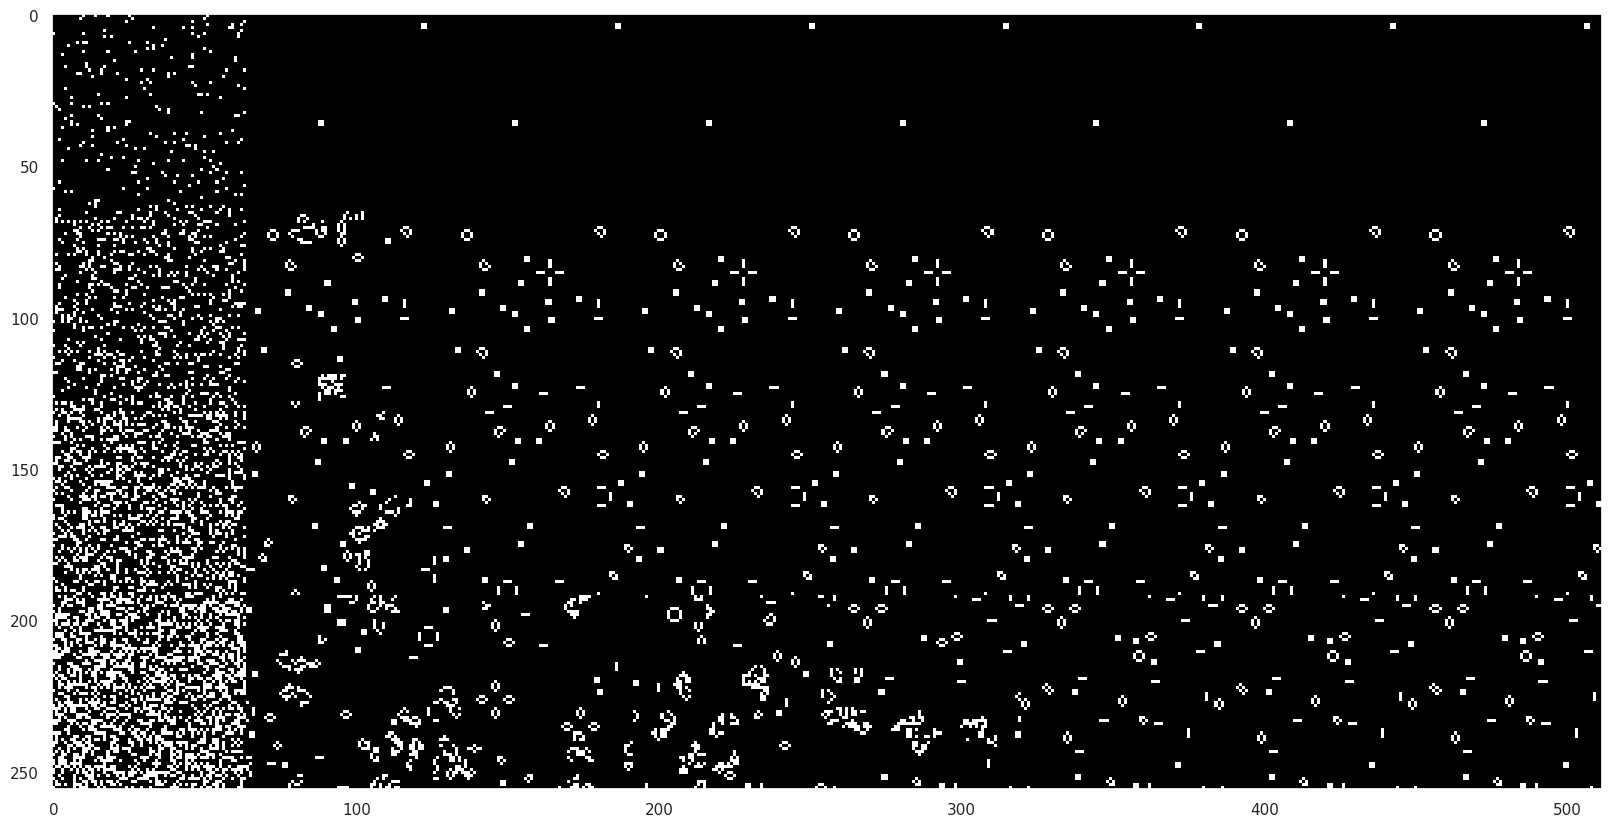

((4096, 128, 128, 3), (256, 512, 3))

In [188]:
vid, img = show_ca(gol, show=True)
vid.shape, img.shape

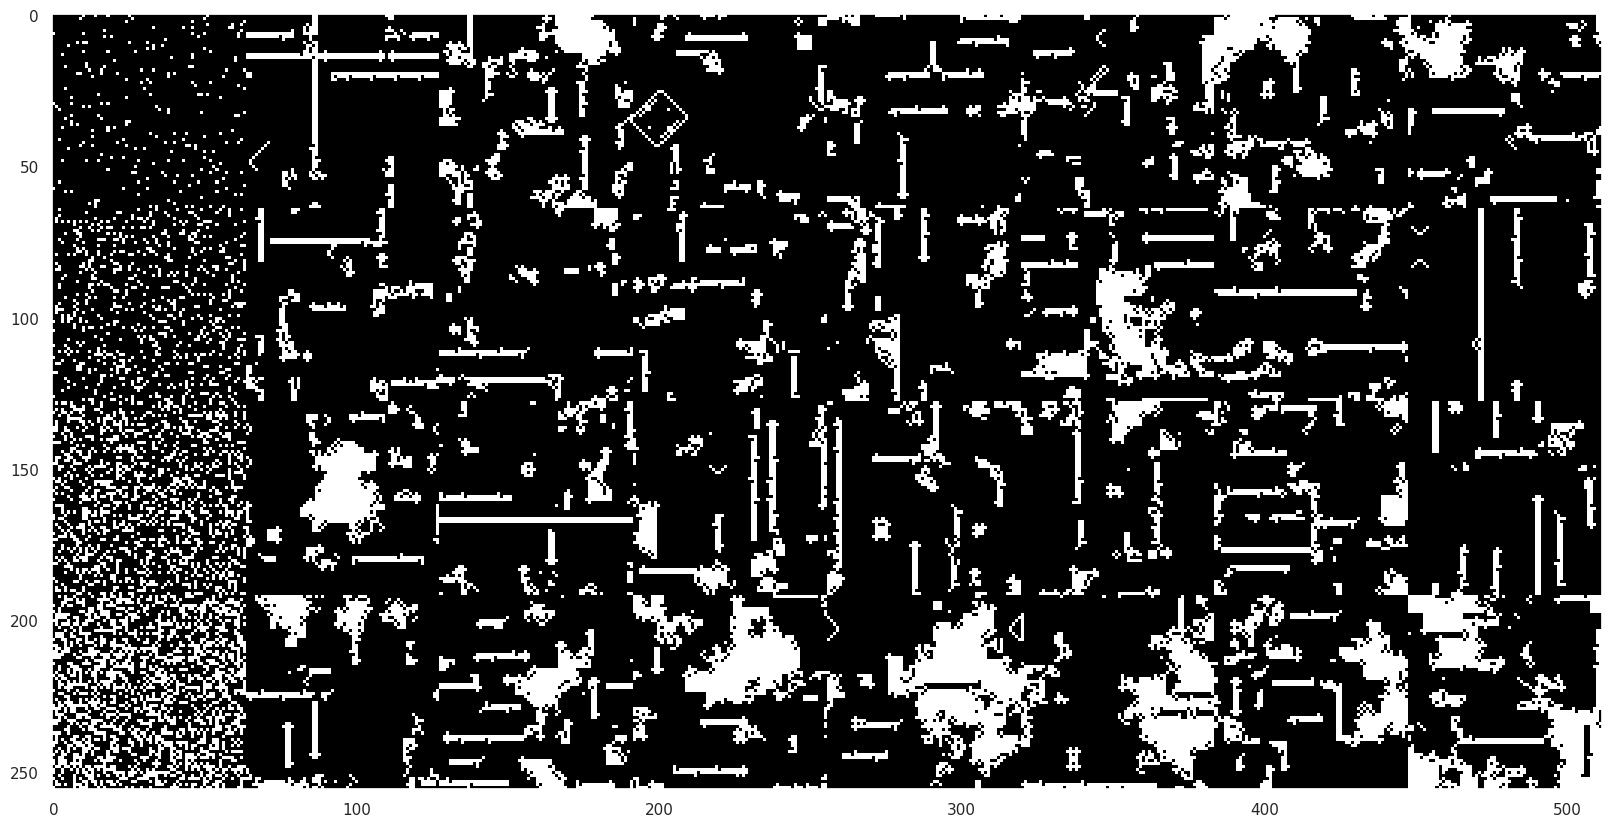

((4096, 128, 128, 3), (256, 512, 3))

In [189]:
vid, img = show_ca(7803, show=True)
vid.shape, img.shape


In [197]:
for i, p in enumerate(tqdm(oe.argsort()[:20])):
    vid, img = show_ca(p)
    print(vid.shape)
    imageio.mimwrite(f'./temp/gol_{i}_{p}.gif', np.array(vid)[:2048:2], fps=30)

  0%|          | 0/20 [00:00<?, ?it/s]

(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)
(4096, 128, 128, 3)


In [204]:
vid, img = show_ca(gol)
imageio.mimwrite(f'./temp/gol__{gol}.gif', np.array(vid)[:2048:2], fps=30)

In [205]:
gol

6152

In [172]:
import imageio
imageio.mimwrite(f'./temp/gol.gif', np.array(vid)[::2], fps=20)

In [201]:
oe.argsort()[:20]

array([  7803,   7291, 133519,  34591,  14782,  34335,  33823,  55871,
        55615,   2067,   2579,  47999,   3731,   3219,  35615,  15411,
        55903,  36703,   8059,  53007])

In [200]:
all_params[7803].reshape(2, 9)

array([[1, 1, 0, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=int32)

In [8]:
from clip_jax import MyFlaxCLIP
resize_fn = partial(jax.image.resize, shape=(224, 224), method='nearest')
clip_model = MyFlaxCLIP()

/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2024-08-10 05:22:58.269481: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [11]:
def conv2d_3x3_sum(x):
    x_padded = jnp.pad(x, pad_width=1, mode='wrap')
    kernel = jnp.ones((3, 3))
    return jax.lax.conv_general_dilated(
            x_padded[None, None, :, :],  # Add batch and channel dimensions
            kernel[None, None, :, :],  # Add input and output channel dimensions
            window_strides=(1, 1),
            padding='VALID',
            dimension_numbers=('NCHW', 'OIHW', 'NCHW'))[0, 0]

def step_ca(state, _, params):
    state_f = state.astype(float)
    n_neighbors = conv2d_3x3_sum(state_f) - state_f
    update_idx = state_f * 9 + n_neighbors
    next_state = params[update_idx.astype(int)]
    return next_state, None

def unroll_ca(state_init, params):
    def chunk_step(state_init, _):
        state, _ = jax.lax.scan(partial(step_ca, params=params), state_init, None, length=64)
        return state, state_init
    _, state_vid = jax.lax.scan(chunk_step, state_init, None, length=32)
    return state_vid

params_gol = jnp.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0])
x_gol_glider = jnp.zeros((32, 32), dtype=int)
x_gol_glider = x_gol_glider.at[:3, :3].set(jnp.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]]))

bs = 256
rng = jax.random.PRNGKey(0)
sparsity = jnp.linspace(.4, .4, num=bs)
state_init = jax.random.uniform(rng, shape=(bs, 64, 64), minval=0, maxval=1)
state_init = jnp.floor(state_init+sparsity[:, None, None]).astype(int)

# @jax.jit
def eval_clip_complexity(params):
    state_vid = jax.vmap(partial(unroll_ca, params=params))(state_init) # B T H W
    print('state_vid ', state_vid.shape)
    vid_clip = jax.vmap(jax.vmap(resize_fn))(state_vid.astype(jnp.float32))
    vid_clip = repeat(vid_clip, "... -> ... 3")
    print('clip vid ', vid_clip.shape)
    z_img = jax.vmap(jax.vmap(clip_model.embed_img))(vid_clip)
    scores = (z_img@z_img.mT)
    print('scores ', scores.shape)
    scores_tril = jax.vmap(partial(jnp.tril, k=-1))(scores)
    similarities = (scores_tril).max(axis=-1)
    return dict(state_vid=state_vid, z_img=z_img, scores=scores, similarities=similarities)

In [10]:
data0 = eval_clip_complexity(params_gol)

state_vid  (256, 32, 64, 64)
clip vid  (256, 32, 224, 224, 3)


2024-08-10 05:23:14.647134: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[8192,768,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[8192,3,224,224]{3,2,1,0}, f32[768,3,32,32]{3,2,1,0}), window={size=32x32 stride=32x32}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2024-08-10 05:23:25.220619: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 11.573585712s
Trying algorithm eng0{} for conv (f32[8192,768,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[8192,3,224,224]{3,2,1,0}, f32[768,3,32,32]{3,2,1,0}), window={size=32x32 stride=32x32}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queu

scores  (256, 32, 32)


In [12]:
data1 = eval_clip_complexity(params_gol)

state_vid  (256, 32, 64, 64)
clip vid  (256, 32, 224, 224, 3)
scores  (256, 32, 32)


(0.98, 1.0)

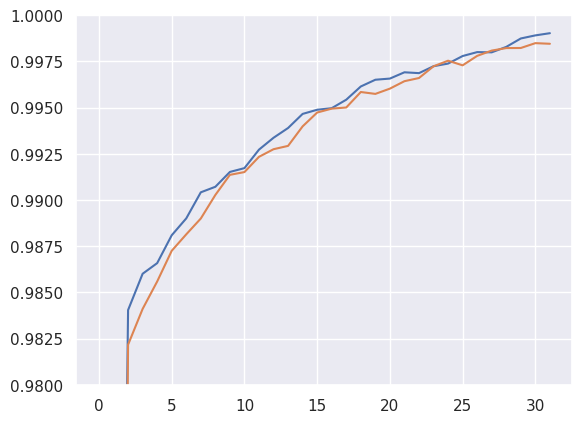

In [17]:
plt.plot(data0['similarities'].mean(axis=0))
plt.plot(data1['similarities'].mean(axis=0))
plt.ylim(0.98, 1.0)